In [1807]:
import numpy as np
import pandas as pd
from scipy import stats

import itertools
import copy
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [1808]:
#data = pd.read_csv('processed_CAR_data.csv')

data = pd.read_csv('close_out_preprocessed_data_20210908.csv')

In [1809]:
# Status from CAR data table
CAR_status = ['Terminated', 'Recruitment Complete', 'Closed',
       'All Activities Closed', 'Planned', 'Completed', 'Reported',
       'Recruiting', 'Enrollment Complete', 'Active, Not Recruiting',
       'Study Terminated', 'Study Withdrawn']

# Status from Scion's table
SCION_status = ['Closed', 'Completed', 'Recruitment Complete', 'Reported', 
                  'All Activities Closed', 'Planned', 'Recruiting']

#data = data[data.ProtocolStatus.isin(SCION_status)]
# data = data.drop(['CloseOut'], axis = 1)
# data.rename(columns = {'CloseOut_new': 'CloseOut'}, inplace = True)

data = data[data.CloseOut <= 200]
data = data[data.CloseOut > 25]

In [1810]:
# Dealing with CROs 
data.loc[:, 'CRO'] = data.CRO.str.replace('Takeda PRA Development Center', 'PRA')
data.loc[:, 'CRO'] = data.CRO.str.replace('PRA Health Sciences', 'PRA')
data.loc[:, 'CRO'] = data.CRO.str.replace('ICON / MAPI / Paradigm', 'ICON')


NON_CORE_CRO = ['Hangzhou Tigermed Consulting', 'Atlant','TBD', 'TFS', 0, '0', 
                'Hammersmith Medicines Research', 'GEICAM', 'INC Research',
                'CMIC', 'Parexel', 'Synteract','Sarah Cannon Research Institut', 
                'Dobbs Consulting', 'In-House','Covance', 'MEDISCIENCE PLANNING INC',
                'EPS', 'A2 Healthcare','Red Maple Trials, Rho, Triumpharma', 
                'Medpace', 'Endpoint', 'Clinical Pharmacology of Miami, INC',
                'Bracket', 'Psi', 'DMID-CROMS Pharmacovigilance Group', 'Chiltern',
                'Assign Group', 'Mediscience Planning Inc.', 'DP Clinical, Inc.', 'ICON', 'MEDISCIENCE']

data.loc[data.CRO.isin(NON_CORE_CRO), 'CRO'] = 'Other'

In [1811]:
def get_plot_labels(group):
    
    if group == 'CRO':
        label_order =  ['IQVIA', 'PRA', 'PPD', 'Celerion', 'Other']
        xaxis = 'CRO'
        xlabel = 'Contract Research Organization'
    elif group == 'TA':
        label_order = ['Oncology', 'NS', 'GI', 'RGH', 'NonCore']
        xaxis = 'TA'
        xlabel = 'Therapeutic Area'
    elif group == 'Phase':
        label_order = ['I', 'II', 'III', 'IV']
        xaxis = 'Phase'
        xlabel = 'Phase'
    
    return label_order, xaxis, xlabel

In [1812]:
def get_row_order(label_order):
    '''
    Takes in the order of the labels for a group and returns the priority index
    to be used for future sorting
    '''
    
    label_dict = dict()
    
    i = 1
    for label in label_order:
        label_dict[label] = i
        i += 1
    
    return label_dict

In [1813]:
label_order = ['IQVIA', 'PRA', 'PPD', 'Celerion', 'Other']

In [1814]:
label_dict = get_row_order(label_order)

In [1815]:
def get_priority(label_dict, group, label):
    '''
    Given an order of priorities, return the priority for the given label
    '''
    priority = label_dict[label]
    return priority 

In [1816]:
def fix_median_df(median_df, group, label_dict):
    '''
    Takes in median_df and returns ordered df in accordance with the desired label order
    '''
    median_df['Order'] = median_df.loc[:, group]
    median_df.Order = median_df.Order.apply(lambda x: get_priority(label_dict, group, label = x)) 
    median_df = median_df.sort_values(by ='Order')
    
    return median_df

In [1817]:
def get_window_plots(df, yrs, group): 
    '''
    Functon that, given a subset df (corresponding to time window) provides specific datasets
    '''
    size = df.shape[0]
    
    print(f'The sample size for the {yrs} window is of {size} observations')
        
    xaxis = 'CloseOut'
    xlabel = 'Close Out (days)'
    
    label_order, yaxis, ylabel = get_plot_labels(group)
    label_dict = get_row_order(label_order)
    
    median_df = df.groupby(by =[group]).agg({'CloseOut': 'median'}).reset_index()    
    median_df = fix_median_df(median_df, group, label_dict)
      
    # Calculates occurrences by categories
    valueCounts = df.loc[:, yaxis].value_counts()    
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale=1)
    sns.set_style('ticks')
    sns.set_palette('cool')

    ax = sns.scatterplot(x = xaxis, 
                    y = yaxis, 
                    data = median_df, 
                    marker = 's',
                    s = 400,
                    color = 'darkviolet',
                    label = 'Group Median')

    
    ax = sns.stripplot(x = xaxis, 
                     y = yaxis,
                     orient = 'h', 
                     data = df, 
                     color='lightcoral', 
                     s = 8,
                     order = label_order)
    

    ax.set(xlim = (0,250))
    
    plt.axvline(x=33, color='maroon', linestyle='--',lw = 2, label = 'Top Quartile')
    plt.axvline(x=52, color='firebrick', linestyle='-', lw = 2, label = 'Industry Median')
    plt.axvline(x=82, color='r', linestyle='--',lw = 2, label = 'Bottom Quartile')
    
    
    plt.xlabel(xlabel,fontsize = 15)
    plt.ylabel(ylabel,fontsize =15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    plt.legend(loc = 'best', fontsize = 16)
    plt.savefig(f'CAR_{yrs}_by_{group}_new.png')
    plt.show()
    print(valueCounts)
    
    pass

In [1818]:
def get_date_df(lower_date_bound, upper_date_bound, data):
    
    temp_conditions_DBL = (lower_date_bound < data['DBL_ActualDate'])&(data['DBL_ActualDate']< upper_date_bound)
    temp_conditions_LSO = (data['LSO_ActualDate']< upper_date_bound)

    temp_df = data[temp_conditions_LSO&temp_conditions_DBL]

    sub_df = temp_df[temp_df.CloseOut < 250] 
    sub_df = temp_df[temp_df.CloseOut > 25]
    
#    wanted_columns = ['ProtocolNum', 'ProtocolPhase','TA','CRO','CloseOut']
    wanted_columns = ['ProtocolNum', 'ProtocolPhase','TA','CRO','CloseOut_new']

    df = sub_df[wanted_columns]
    df.columns = ['TrialID', 'Phase', 'TA', 'CRO', 'CloseOut']
    
    
    df = df[df.Phase != '0']
    
    
    return df

In [1819]:
# Assigning the upper and lower date bounds based on the 3-year trailing value based on calendar years 

def get_date_boundaries(period):
    '''
    Returns the date boundarires based on whether the desired period to be analysed is Fiscal or Calendar full-year
    '''
    if period == 'Calendar':
        dates = {'16_18': ['2016-01-01', '2019-01-01'], '17_19': ['2017-01-01', '2020-01-01'], 
                 '18_20': ['2018-01-01', '2021-01-01'],'19_21': ['2019-01-01', '2022-01-01'],
                 'Covid19':['2020-03-15', '2021-03-31'],'PreCovid': ['2018-01-01', '2020-03-15']}
    elif period == 'Fiscal':
        dates = {'16_18': ['2016-04-01', '2019-03-31'], '17_19': ['2017-04-01', '2020-03-31'], 
                 '18_20': ['2018-04-01', '2021-03-31'],'19_21': ['2019-04-01', '2022-03-31'],
                 'Covid19':['2020-03-15', '2021-03-31'],'PreCovid': ['2018-01-01', '2020-03-15']} 
    return dates

In [1820]:
dates = get_date_boundaries('Calendar')


In [1821]:
groups = ['CRO', 'Phase', 'TA']

Generating plots for 16_18 window...
The sample size for the 16_18 window is of 102 observations


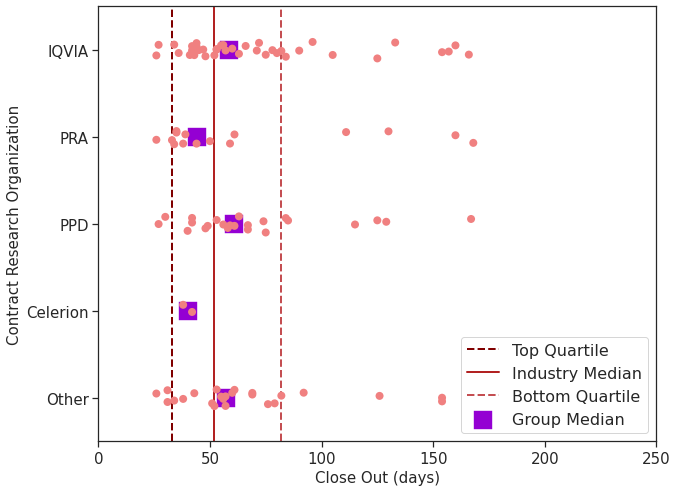

IQVIA       38
Other       24
PPD         23
PRA         15
Celerion     2
Name: CRO, dtype: int64
The sample size for the 16_18 window is of 102 observations


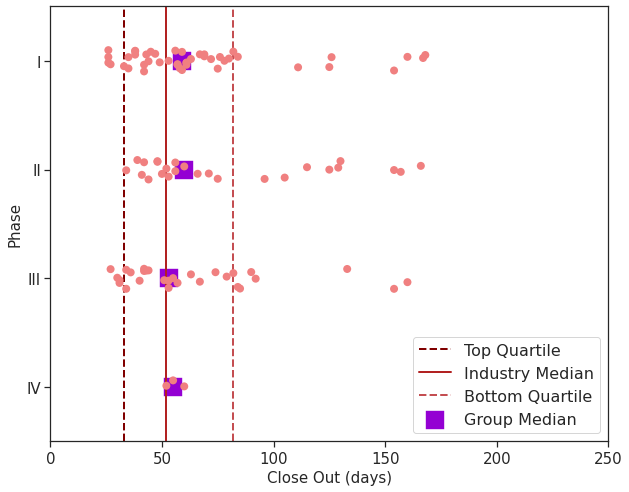

I      45
III    29
II     25
IV      3
Name: Phase, dtype: int64
The sample size for the 16_18 window is of 102 observations


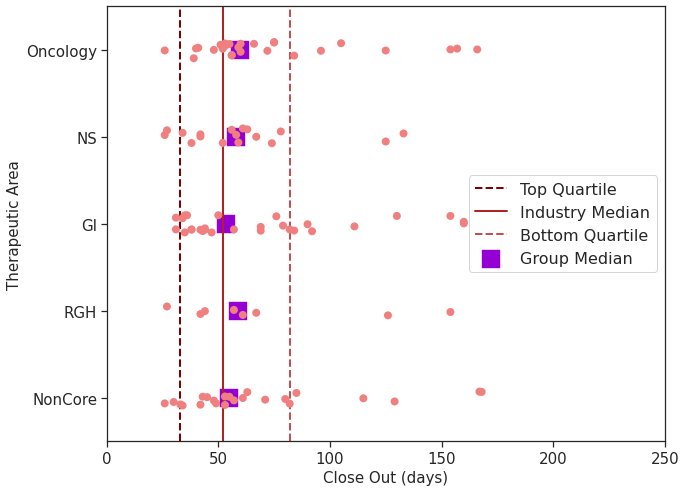

GI          28
Oncology    26
NonCore     23
NS          17
RGH          8
Name: TA, dtype: int64
Generating plots for 17_19 window...
The sample size for the 17_19 window is of 130 observations


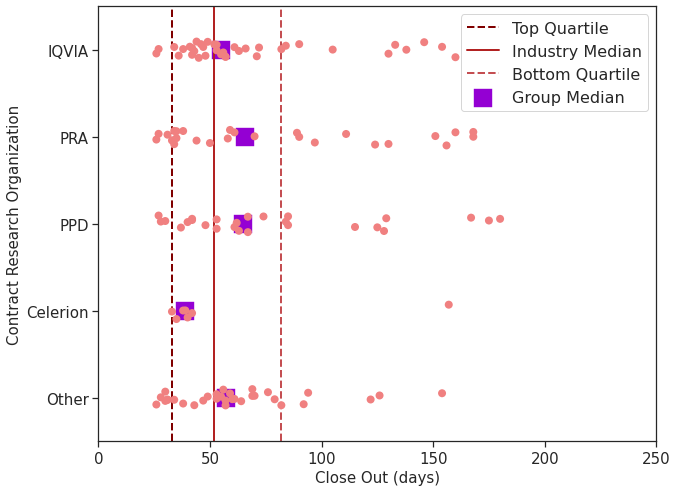

IQVIA       37
Other       32
PRA         28
PPD         26
Celerion     7
Name: CRO, dtype: int64
The sample size for the 17_19 window is of 130 observations


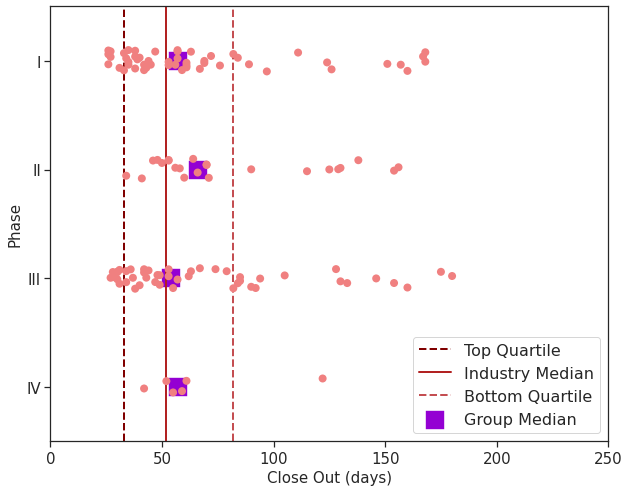

I      53
III    48
II     23
IV      6
Name: Phase, dtype: int64
The sample size for the 17_19 window is of 130 observations


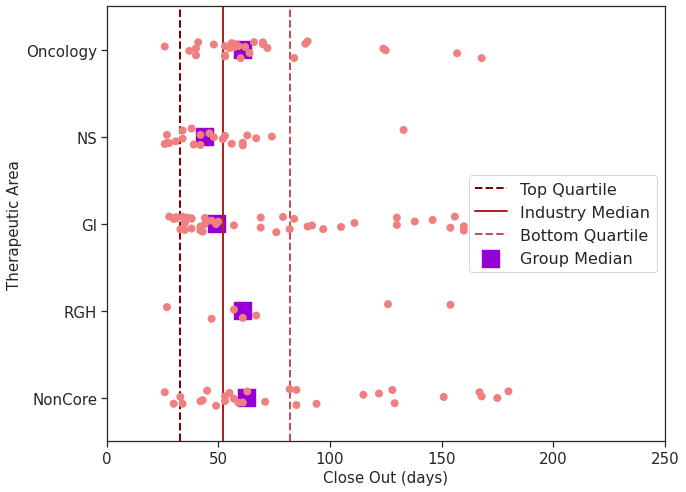

GI          42
Oncology    30
NonCore     29
NS          22
RGH          7
Name: TA, dtype: int64
Generating plots for 18_20 window...
The sample size for the 18_20 window is of 146 observations


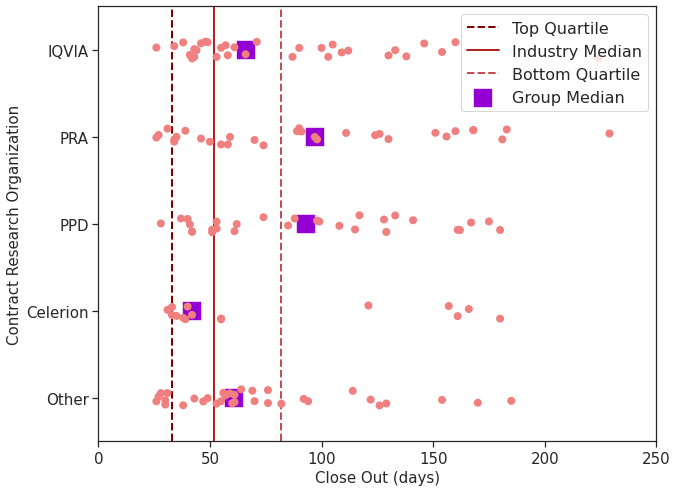

PRA         35
IQVIA       33
Other       33
PPD         30
Celerion    15
Name: CRO, dtype: int64
The sample size for the 18_20 window is of 146 observations


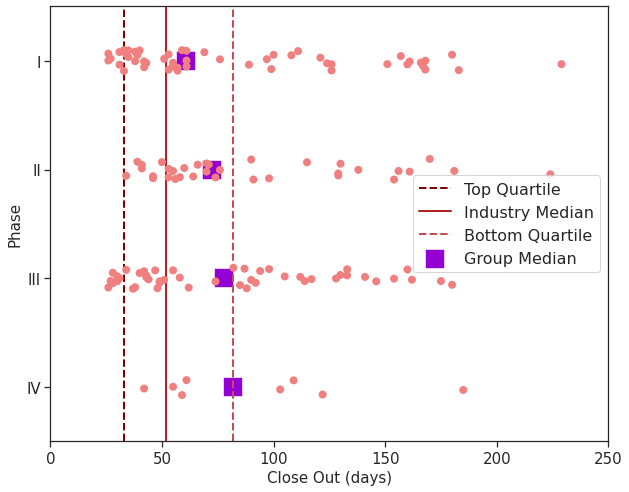

I      54
III    48
II     36
IV      8
Name: Phase, dtype: int64
The sample size for the 18_20 window is of 146 observations


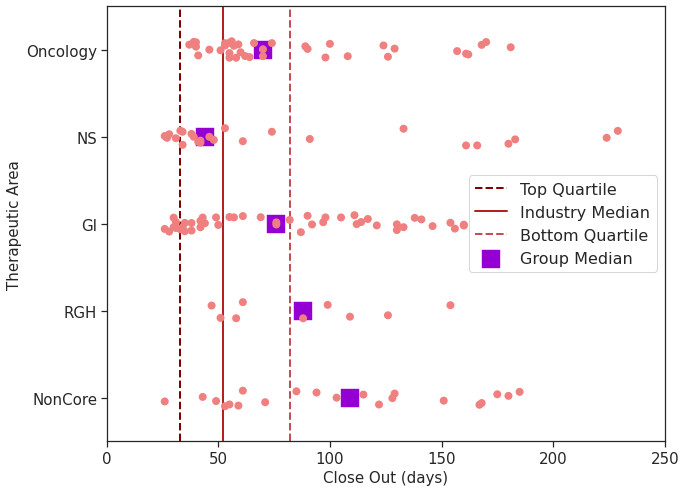

GI          48
Oncology    41
NS          26
NonCore     22
RGH          9
Name: TA, dtype: int64
Generating plots for 19_21 window...
The sample size for the 19_21 window is of 117 observations


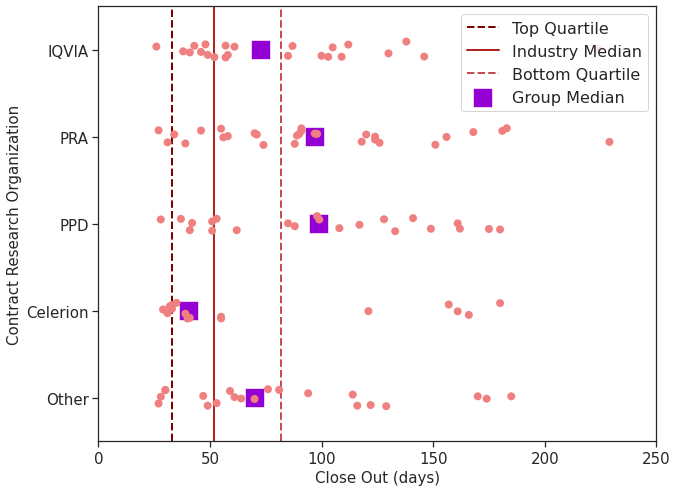

PRA         33
IQVIA       24
PPD         23
Other       21
Celerion    16
Name: CRO, dtype: int64
The sample size for the 19_21 window is of 117 observations


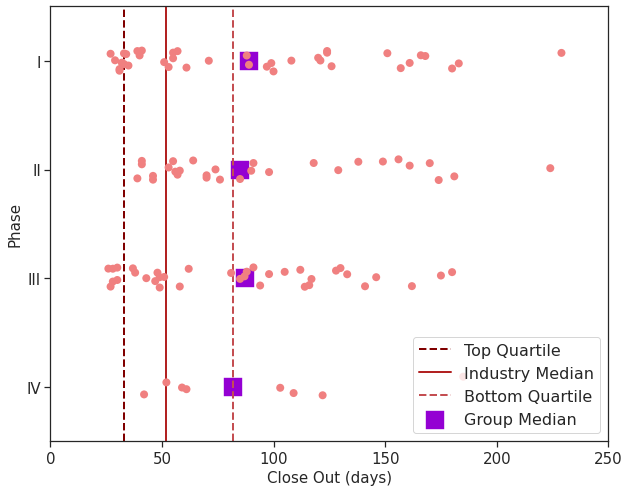

I      41
III    37
II     31
IV      8
Name: Phase, dtype: int64
The sample size for the 19_21 window is of 117 observations


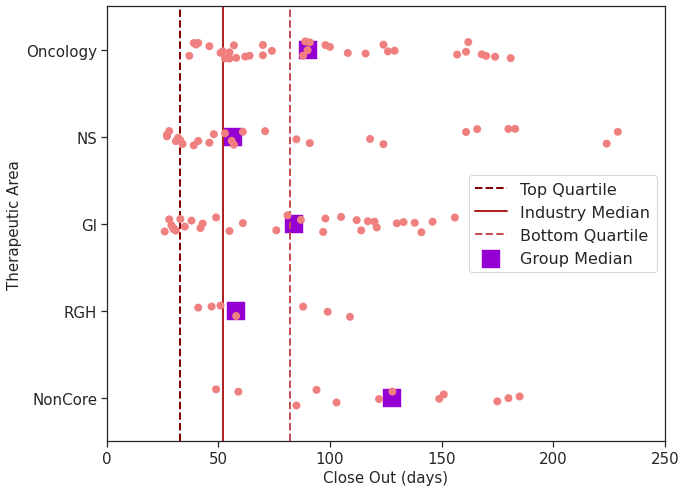

Oncology    39
GI          32
NS          26
NonCore     13
RGH          7
Name: TA, dtype: int64
Generating plots for Covid19 window...
The sample size for the Covid19 window is of 53 observations


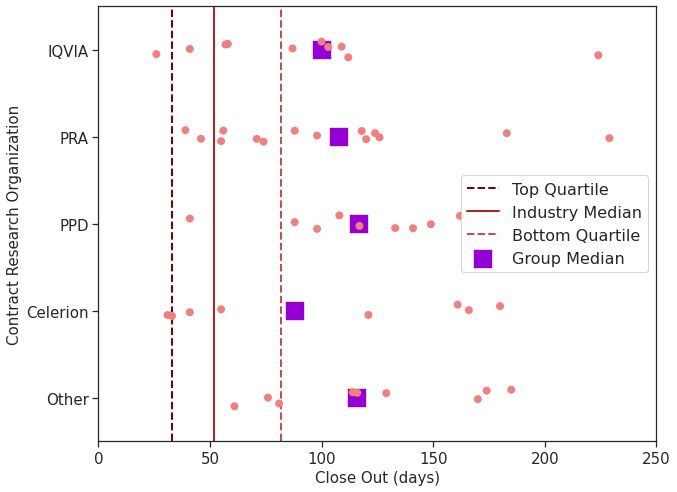

PRA         16
IQVIA       11
PPD          9
Other        9
Celerion     8
Name: CRO, dtype: int64
The sample size for the Covid19 window is of 53 observations


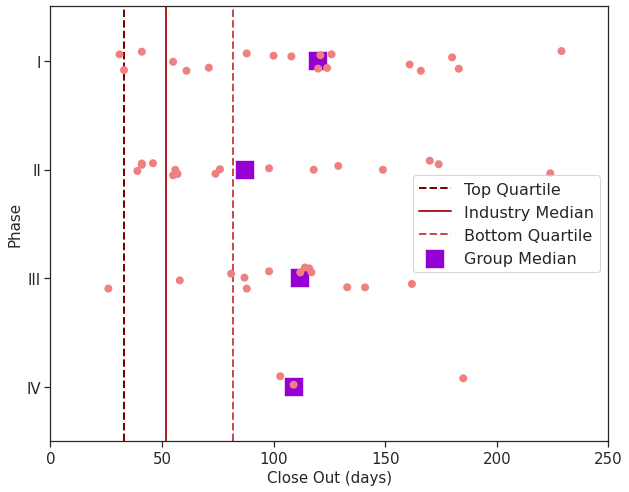

I      19
II     18
III    13
IV      3
Name: Phase, dtype: int64
The sample size for the Covid19 window is of 53 observations


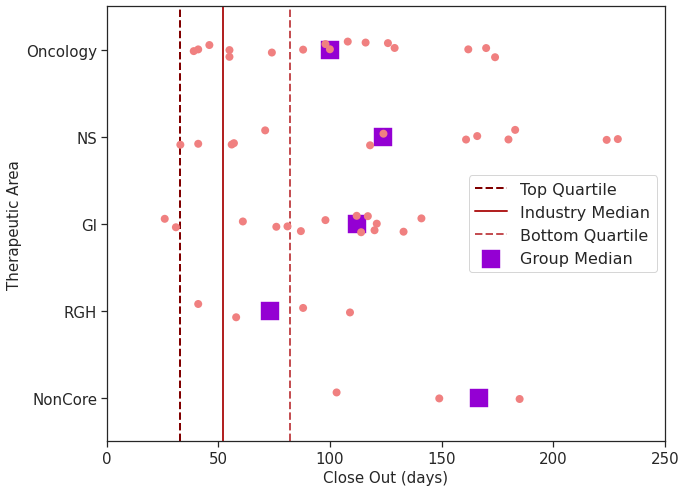

Oncology    17
GI          15
NS          13
NonCore      4
RGH          4
Name: TA, dtype: int64
Generating plots for PreCovid window...
The sample size for the PreCovid window is of 106 observations


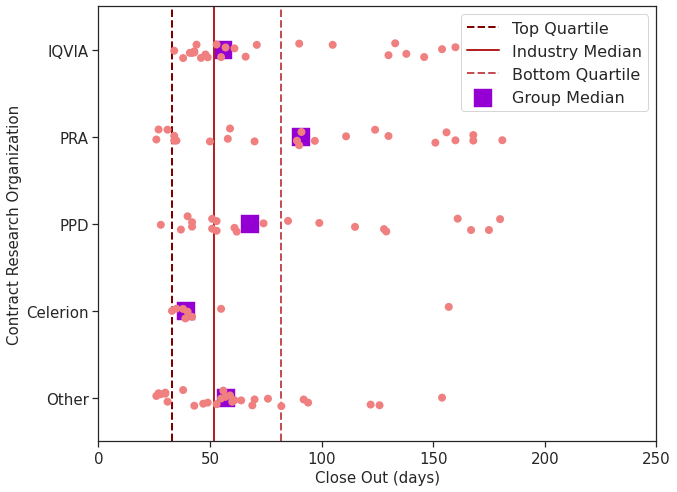

Other       27
PRA         25
IQVIA       24
PPD         22
Celerion     8
Name: CRO, dtype: int64
The sample size for the PreCovid window is of 106 observations


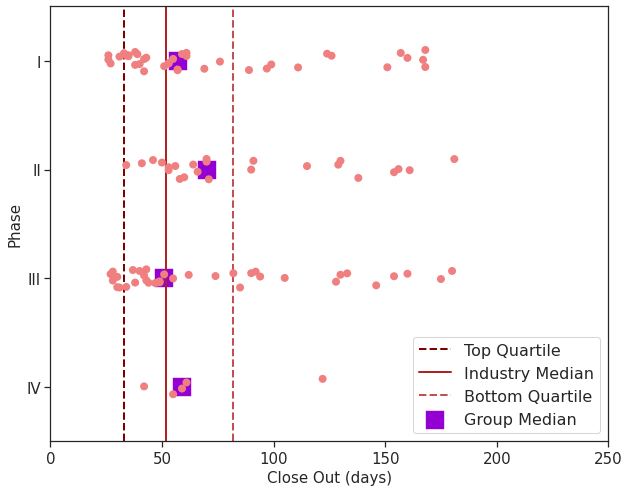

I      40
III    37
II     24
IV      5
Name: Phase, dtype: int64
The sample size for the PreCovid window is of 106 observations


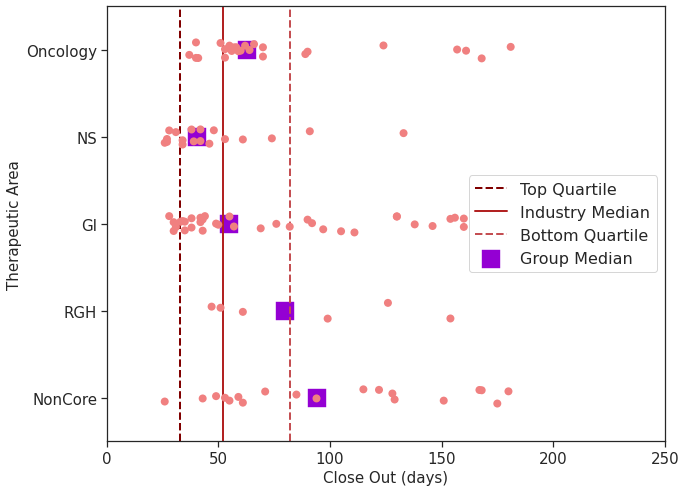

GI          35
Oncology    28
NonCore     19
NS          18
RGH          6
Name: TA, dtype: int64


In [1822]:
i = 0
for yrs in dates:
    if i < 100:
        print(f'Generating plots for {yrs} window...')
        lower_date_bound = dates[yrs][0]
        upper_date_bound = dates[yrs][1]

        df = get_date_df(lower_date_bound, upper_date_bound, data)

        for group in groups:
            med_df = get_window_plots(df, yrs, group)
    i += 1

In [ ]:
# Taking values from 2016-2019
lower_date_bound = '2005-12-31'
upper_date_bound = '2025-01-01'
totdf = get_date_df(lower_date_bound, upper_date_bound, data)


In [1823]:
totdf.shape

(253, 5)

In [1825]:
#totdf.to_csv('post_plots_CAR.csv')

In [246]:
lower_date_bound = '2019-12-31'
upper_date_bound = '2021-01-01'

covid_df = get_date_df(lower_date_bound, upper_date_bound, data)

In [249]:
sub_df.TA.unique()

array(['GI', 'NS', 'NonCore', 'Oncology', 'RGH'], dtype=object)

In [1706]:
calendar_year_windows_2 = {'16': ['2016-01-01', '2017-01-01'], 
                           '17': ['2017-01-01', '2018-01-01'], 
                           '18': ['2018-01-01', '2019-01-01'],
                           '19': ['2019-01-01', '2020-01-01'],
                           '20': ['2020-01-01', '2021-01-01']}

fiscal_year_windows_2 = {'16': ['2016-04-01', '2017-03-31'], 
                         '17': ['2017-04-01', '2018-03-31'], 
                         '18': ['2018-04-01', '2019-03-31'],
                         '19': ['2019-04-01', '2020-03-31'],
                         '20': ['2020-04-01', '2021-03-31']}
                         #'Covid19':['2020-03-15', '2021-03-31']}


dates = fiscal_year_windows_2
close_out_dict = dict()

for yrs in dates:
    #print(f'Generating plots for {yrs} window...')
    lower_date_bound = dates[yrs][0]
    upper_date_bound = dates[yrs][1]
    
    df = get_date_df(lower_date_bound, upper_date_bound, data)
    

    close_out = list(df.CloseOut)

    close_out_dict[yrs] = close_out

    windows = [window for window in close_out_dict.values()] 

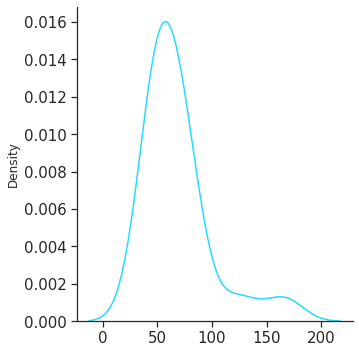

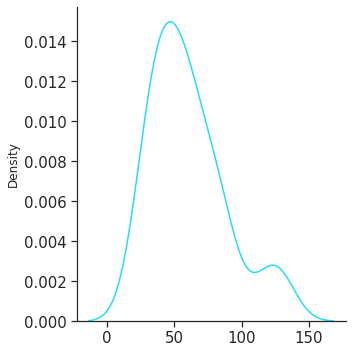

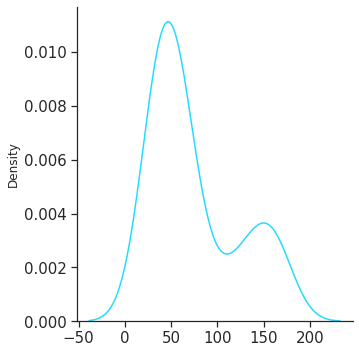

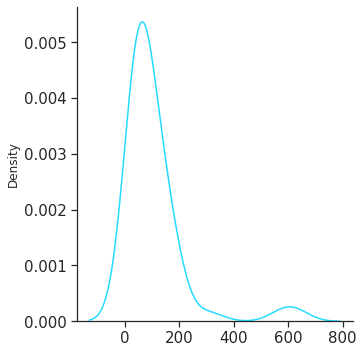

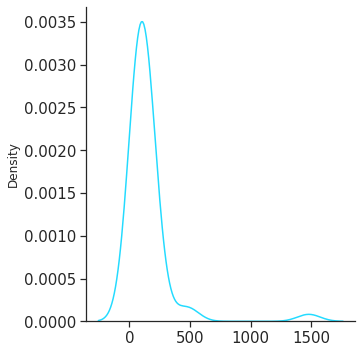

In [1707]:
for key in close_out_dict:
    vals = close_out_dict[key]
    sns.displot(vals, kind = 'kde')
    #ax.set_xlabel('Close Out (days)')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.savefig('distplot_windows.png')

19 obs in 16 window
41 obs in 17 window
46 obs in 18 window
51 obs in 19 window
52 obs in 20 window


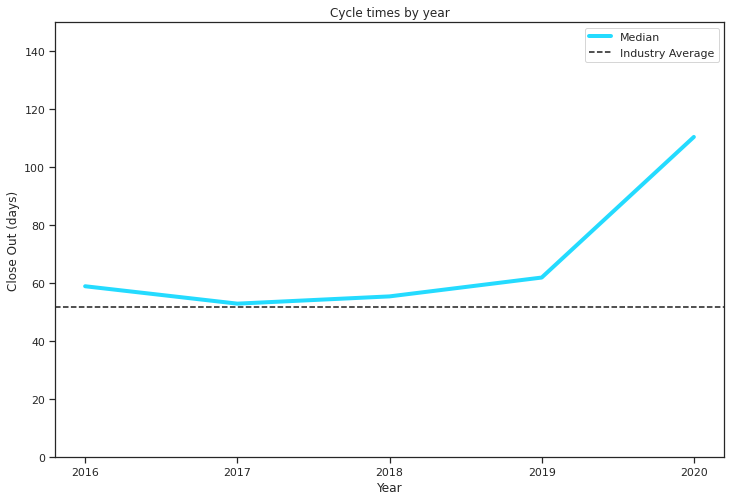

In [1714]:
temp_ls = list(dates)

i = 0

means = list()
medians = list()
years  = ['2016', '2017', '2018', '2019', '2020']#, 'Covid19']

for window in windows:
    print(f'{len(window)} obs in {temp_ls[i]} window')
     
    means.append(round(np.mean(window),2))
    medians.append(round(np.median(window),2))
    
    i+=1
    
plt.figure(figsize = (12,8))
plt.xlabel('Year')
plt.ylabel('Close Out (days)')
plt.title('Cycle times by year')

plt.ylim((0,150))

#plt.barplot(years, means, label = 'Mean')
#plt.bar(years, medians, label = 'Median')
#plt.plot(years,means, label = 'Mean')
plt.plot(years,medians, lw = 4, label = 'Median')
plt.axhline(y=52, color='k', linestyle='--', label = 'Industry Average')
#plt.plot([70, 70], [100, 250], 'k-', lw=2)
plt.legend(loc = 'best')
plt.savefig('cycletimeplots.png')

In [266]:
from scipy import stats

In [267]:
def compute_ks_test(list_of_combinations, pvalue_thresh):
    
    '''
    Given a list of combinations of sample data, compute the KS test and return the number of tests that were passed 
    '''
    test_vals = list()
    
    for combination in list_of_combinations:
        sample_1 = combination[0]
        sample_2 = combination[1]
        
        test_pvalue = stats.ks_2samp(sample_1,sample_2).pvalue
        test_vals.append(test_pvalue)
        
        
    i=0
    t=0
    for val in test_vals:
        t+=1
        if val <= pvalue_thresh:
            print(f'Null hypothesis rejected for test t = {t}')
            i+=1


    print(f'Null hypothesis rejected in {i} tests')
    return test_vals

In [275]:
pvalue_thresh = 0.05

fiscal_windows = windows
list_of_combinations = list(itertools.combinations(fiscal_windows, 2))
test_vals = compute_ks_test(list_of_combinations, pvalue_thresh)

Null hypothesis rejected for test t = 8
Null hypothesis rejected for test t = 9
Null hypothesis rejected for test t = 11
Null hypothesis rejected for test t = 12
Null hypothesis rejected in 4 tests


,TrialID,Phase,TA,CRO,CloseOut
6,1-1CJZCS,I,NS,PPD,63
7,1-1DC1ZJ,I,NS,PRA,26
9,1-1EIATT,III,NonCore,IQVIA,57
10,1-1EIAU4,III,NonCore,IQVIA,63
11,1-1EIAUN,III,NonCore,IQVIA,53
...,...,...,...,...,...
281,VV_DEN_205,II,NonCore,PPD,115
300,VV_IPV_102,I,NonCore,PRA,168
305,VV_NOR_202,II,NonCore,IQVIA,71
306,VV_NOR_204,II,NonCore,PPD,129


,CRO,TrialID
1,IQVIA,62
3,PPD,55
2,Other,54
4,PRA,45
0,Celerion,18


In [1662]:
def get_trial_plots(df, group, label_order):

    plt.figure(figsize = (10,8))
    plt.title(f'Distribution of Trials by {group}')
    sns.barplot(df.loc[:, group], df.loc[:, 'TrialID'], 
            color = 'r', order = label_order)

    plt.xlabel(f'{group}')
    plt.ylabel('# Trials')
    plt.show()
    
    plt.savefig(f'Trials_by_{group}.png')

    pass

In [1663]:
groups = ['CRO', 'TA', 'Phase']

label_orders = [['IQVIA', 'PPD', 'PRA', 'Celerion', 'Other'],
                ['Oncology', 'GI', 'NS', 'RGH', 'NonCore'],
                ['I', 'II', 'III', 'IV']]


/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


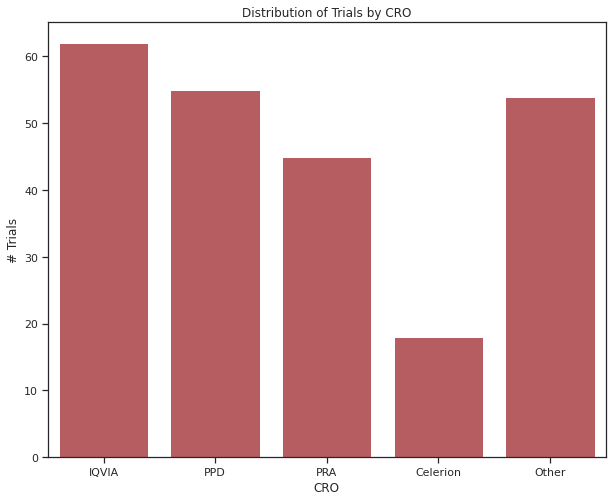

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 842.4x595.44 with 0 Axes>

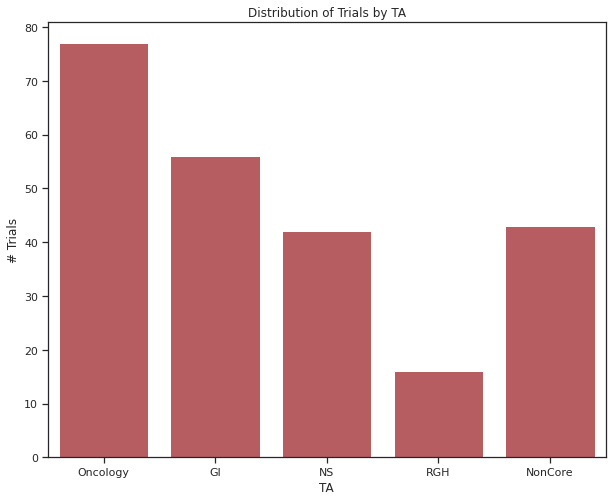

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 842.4x595.44 with 0 Axes>

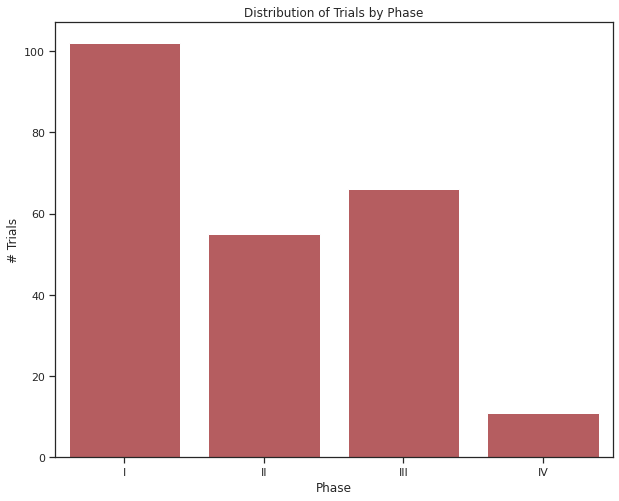

<Figure size 842.4x595.44 with 0 Axes>

In [1664]:
i = 0
for group in groups:
    temp_df = totdf.groupby(by=[group]).agg({'TrialID': 'count'}).reset_index()#.sort_values('TrialID', ascending = False)
    label_order = label_orders[i]
    
    get_trial_plots(df = temp_df, group = group, label_order = label_order)
    i +=1 